# Image classification using VGG16 & keras data augmentation

**Libraries**

In [30]:
from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from util import plot_confusion_matrix

**Creating sample dataset**

In [33]:
import os

def mkdir(p):
    if not os.path.exists(p):
        os.mkdir(p)

def link(src, dst):
    if not os.path.exists(dst):
        os.symlink(src, dst, target_is_directory=True)

mkdir('C:/Users/Thatoi/target/')


classes = [
  'Apple Golden 1',
  'Avocado',
  'Lemon',
  'Mango',
  'Kiwi',
  'Banana',
  'Strawberry',
  'Raspberry'
]

train_path_from = os.path.abspath('C:/Users/Thatoi/fruits/fruits-360_dataset/fruits-360/Training')
valid_path_from = os.path.abspath('C:/Users/Thatoi/fruits/fruits-360_dataset/fruits-360/Test')

train_path_to = os.path.abspath('C:/Users/Thatoi/target/train')
valid_path_to = os.path.abspath('C:/Users/Thatoi/target/test')

mkdir(train_path_to)
mkdir(valid_path_to)


for c in classes:
    link(train_path_from + '/' + c, train_path_to + '/' + c)
    link(valid_path_from + '/' + c, valid_path_to + '/' + c)

**Image preprocessing**

In [8]:
# re-size all the images to this
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

# training config:
epochs = 5
batch_size = 32

train_path = 'C:/Users/Thatoi/target/train'
valid_path = 'C:/Users/Thatoi/target/test'

# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')

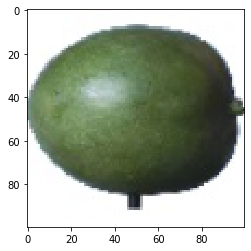

In [3]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

**VGG16 modification**

In [4]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)


# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()





58892288/58889256 [==============================] - 20s 0us/step






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________


**Image augmentation**

In [17]:
# create an instance of ImageDataGenerator
#Given that our network is constantly seeing new, 
#slightly modified versions of the input data, 
#the network is able to learn more robust features.

gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

In [18]:
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

Found 1289 images belonging to 8 classes.
{'Apple Golden 1': 0, 'Avocado': 1, 'Banana': 2, 'Kiwi': 3, 'Lemon': 4, 'Mango': 5, 'Raspberry': 6, 'Strawberry': 7}


min: -106.32279 max: 151.061


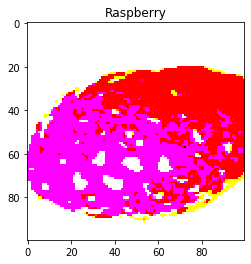

In [19]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break


**VGG16 and Image augmentation**

In [26]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 3839 images belonging to 8 classes.
Found 1289 images belonging to 8 classes.


In [28]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

**Fitting the model**

In [29]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
119/119 [==============================] - 1106s 9s/step - loss: 2.5766 - acc: 0.8264 - val_loss: 2.1548 - val_acc: 0.8617
Epoch 2/5
119/119 [==============================] - 1326s 11s/step - loss: 2.0703 - acc: 0.8705 - val_loss: 2.1237 - val_acc: 0.8624
Epoch 3/5
119/119 [==============================] - 1344s 11s/step - loss: 2.0322 - acc: 0.8729 - val_loss: 2.0843 - val_acc: 0.8695
Epoch 4/5
119/119 [==============================] - 1323s 11s/step - loss: 2.1118 - acc: 0.8684 - val_loss: 2.1714 - val_acc: 0.8600
Epoch 5/5
119/119 [==============================] - 1292s 11s/step - loss: 2.0351 - acc: 0.8731 - val_loss: 2.2300 - val_acc: 0.8600


**Model performance**

In [31]:
def get_confusion_matrix(data_path, N):
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break

    cm = confusion_matrix(targets, predictions)
    return cm

Generating confusion matrix 3839
Found 3839 images belonging to 8 classes.
50
[[481   0   0   0  11   0   0   0]
 [  0 427   0   0   0   0   0   0]
 [  0   0 490   0   0   0   0   0]
 [  0   0   0 466   0   0   0   0]
 [  0   0   0   0 492   0   0   0]
 [  0 483   0   0   7   0   0   0]
 [  0   0   0   0   0   0 490   0]
 [  0   0   0   0   0   0   0 492]]
Generating confusion matrix 1289
Found 1289 images belonging to 8 classes.
[[147   0   0   0  17   0   0   0]
 [  0 143   0   0   0   0   0   0]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [  0   0   1   0 163   0   0   0]
 [  0 164   0   0   2   0   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]


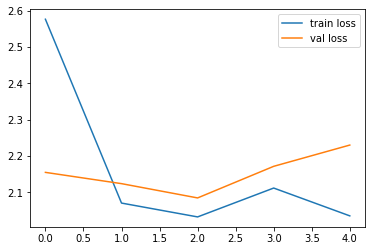

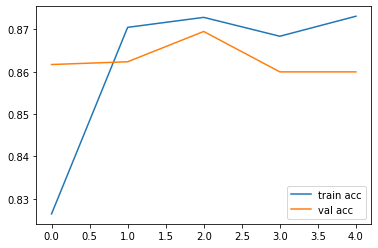

Confusion matrix, without normalization
[[481   0   0   0  11   0   0   0]
 [  0 427   0   0   0   0   0   0]
 [  0   0 490   0   0   0   0   0]
 [  0   0   0 466   0   0   0   0]
 [  0   0   0   0 492   0   0   0]
 [  0 483   0   0   7   0   0   0]
 [  0   0   0   0   0   0 490   0]
 [  0   0   0   0   0   0   0 492]]


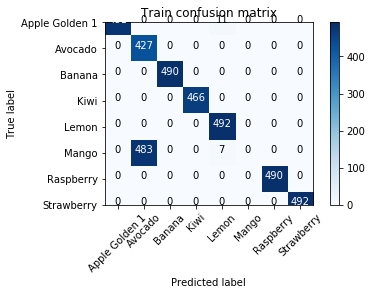

Confusion matrix, without normalization
[[147   0   0   0  17   0   0   0]
 [  0 143   0   0   0   0   0   0]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [  0   0   1   0 163   0   0   0]
 [  0 164   0   0   2   0   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]


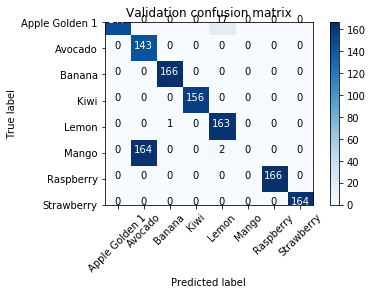

In [32]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')